#  **Breast Tumor Classification Using Histopathological Images**

##  **Introduction**
Breast cancer is one of the most prevalent and life-threatening diseases among women worldwide.  
Early and accurate diagnosis using histopathological images can significantly improve treatment outcomes.  

This project aims to develop a **Convolutional Neural Network (CNN)** capable of classifying **benign vs malignant** tumor tissue images using the **BreakHis dataset**.  

###  **Research Questions**
1. Can CNN models accurately classify benign vs malignant tumor tissue images?
2. Which visual features (texture, shape, patterns) are most influential, and can explainability methods such as **Grad-CAM** highlight them?
3. How does model performance vary across magnification levels (200× and 400×), and can models generalize across magnifications?

###  **Dataset Information**
- **Name:** BreakHis – Breast Cancer Histopathological Database  
- **Source:** [Mendeley Data – BreakHis Dataset](https://data.mendeley.com/datasets/jxwvdwhpc2/1)  
- **Contributors:** Mayke Pereira et al., Instituto Federal de Educação, Ciência e Tecnologia do Espírito Santo, Brazil  
- **Data Type:** RGB images (224 × 224 px) of breast-tumor tissues at magnifications 40×, 100×, 200×, 400×  
- **Labels:** Benign (0) / Malignant (1)


# **Setup and Dataset Download**

In [ ]:
!apt-get install wget -q
!wget -O breakhis.zip "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jxwvdwhpc2-1.zip"
!unzip -q breakhis.zip -d /content/breakhis_dataset

import os
base_dir = "/content/breakhis_dataset"
print(" Dataset downloaded and extracted at:", base_dir)


Reading package lists...
Building dependency tree...
Reading state information...
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
--2025-11-04 10:39:19--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jxwvdwhpc2-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.120.202, 52.92.16.194, 52.218.120.130, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.120.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1795182968 (1.7G) [application/zip]
Saving to: ‘breakhis.zip’

breakhis.zip        100%[===================>]   1.67G  7.64MB/s    in 2m 50s  

2025-11-04 10:42:11 (10.1 MB/s) - ‘breakhis.zip’ saved [1795182968/1795182968]

 Dataset downloaded and extracted at: /content/breakhi

In [ ]:

#  UNZIP INNER DATASET ARCHIVE


inner_zip = "/content/breakhis_dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1.zip"
extract_dir = "/content/breakhis_dataset/final_dataset"

# Unzip the nested archive
!unzip -q "$inner_zip" -d "$extract_dir"

# Verify extraction
import os
for root, dirs, files in os.walk(extract_dir):
    print(root, "->", len(files), "files")
    break

print(" Inner dataset extracted successfully at:", extract_dir)


/content/breakhis_dataset/final_dataset -> 0 files
 Inner dataset extracted successfully at: /content/breakhis_dataset/final_dataset


##  **Libraries and Initial Inspection**
We’ll import TensorFlow and Keras for model development, and Matplotlib / Seaborn for visual analysis.  
Let’s verify the folder structure and preview the dataset hierarchy.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
magnification = "200X"  # choose among '40X', '100X', '200X', '400X'

base_dir = f"/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria/{magnification}"
for root, dirs, files in os.walk(base_dir):
    print(root, "->", len(files), "files")
    break

print(f" Using magnification level: {magnification}")

/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria/200X -> 0 files
 Using magnification level: 200X


##  **Exploratory Data Analysis (EDA)**
Before training the CNN, we examine the data distribution and visualize sample images from both classes.

Key Objectives:
- Check for balance between benign and malignant classes.  
- View random samples for texture and color differences.  
- Confirm image dimensions and quality.


/tmp/ipython-input-851857030.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="coolwarm")


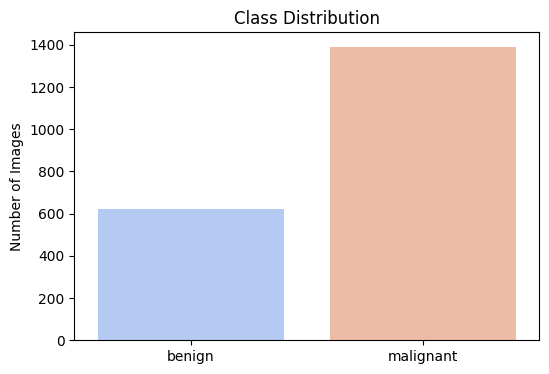

In [ ]:
# Count images per class
class_counts = {'benign': 0, 'malignant': 0}
for subdir, _, files in os.walk(base_dir):
    if 'benign' in subdir.lower():
        class_counts['benign'] += len(files)
    elif 'malignant' in subdir.lower():
        class_counts['malignant'] += len(files)

plt.figure(figsize=(6,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="coolwarm")
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()




In [ ]:
import os


# Initialize counters
class_counts = {'benign': 0, 'malignant': 0}

# Loop through dataset folders and count files
for subdir, _, files in os.walk(base_dir):
    if 'benign' in subdir.lower():
        class_counts['benign'] += len(files)
    elif 'malignant' in subdir.lower():
        class_counts['malignant'] += len(files)

# Print results neatly
print(f" Image Count Summary for {magnification} Magnification")
print("-" * 50)
print(f"Benign Images   : {class_counts['benign']:,}")
print(f"Malignant Images: {class_counts['malignant']:,}")
print(f"Total Images    : {class_counts['benign'] + class_counts['malignant']:,}")
print("-" * 50)

# Optional — Display as DataFrame
import pandas as pd
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image_Count'])
display(df_counts)


 Image Count Summary for 200X Magnification
--------------------------------------------------
Benign Images   : 623
Malignant Images: 1,390
Total Images    : 2,013
--------------------------------------------------


,Image_Count
benign,623
malignant,1390


In [ ]:
import os
import pandas as pd


# Define base paths for both magnifications
base_path = "/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria"
magnifications = ["200X", "400X"]

# Dictionary to store results
results = {}

# Loop over magnifications and count files
for mag in magnifications:
    mag_dir = os.path.join(base_path, mag)
    class_counts = {'benign': 0, 'malignant': 0}

    for subdir, _, files in os.walk(mag_dir):
        if 'benign' in subdir.lower():
            class_counts['benign'] += len(files)
        elif 'malignant' in subdir.lower():
            class_counts['malignant'] += len(files)

    results[mag] = class_counts

# Convert to DataFrame for nice display
df = pd.DataFrame(results).T
df['Total'] = df['benign'] + df['malignant']

# Display results
print("IMAGE COUNT SUMMARY — 200X vs 400X MAGNIFICATION")
print("-" * 60)
display(df)

# Print formatted summary
for mag in magnifications:
    print(f" {mag} Magnification:")
    print(f"   Benign Images   : {results[mag]['benign']:,}")
    print(f"   Malignant Images: {results[mag]['malignant']:,}")
    print(f"   Total Images    : {results[mag]['benign'] + results[mag]['malignant']:,}")
    print("-" * 50)


IMAGE COUNT SUMMARY — 200X vs 400X MAGNIFICATION
------------------------------------------------------------


,benign,malignant,Total
200X,623,1390,2013
400X,588,1232,1820


 200X Magnification:
   Benign Images   : 623
   Malignant Images: 1,390
   Total Images    : 2,013
--------------------------------------------------
 400X Magnification:
   Benign Images   : 588
   Malignant Images: 1,232
   Total Images    : 1,820
--------------------------------------------------


In [ ]:

#  COUNT AND PLOT IMAGES FOR 200X AND 400X MAGNIFICATIONS


import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define base path
base_path = "/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria"
magnifications = ["200X", "400X"]

# Count images
results = {}
for mag in magnifications:
    mag_dir = os.path.join(base_path, mag)
    class_counts = {'Benign': 0, 'Malignant': 0}
    for subdir, _, files in os.walk(mag_dir):
        if 'benign' in subdir.lower():
            class_counts['Benign'] += len(files)
        elif 'malignant' in subdir.lower():
            class_counts['Malignant'] += len(files)
    results[mag] = class_counts

# Convert to DataFrame
df = pd.DataFrame(results).T
df['Total'] = df['Benign'] + df['Malignant']

# Print summary
print(" IMAGE COUNT SUMMARY — 200X vs 400X MAGNIFICATION")
print("-" * 60)
df


 IMAGE COUNT SUMMARY — 200X vs 400X MAGNIFICATION
------------------------------------------------------------


,Benign,Malignant,Total
200X,623,1390,2013
400X,588,1232,1820


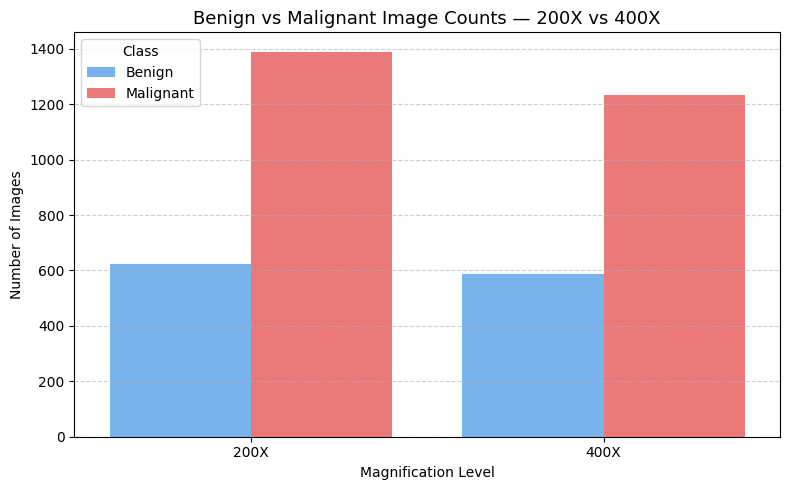

/tmp/ipython-input-3646384783.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y=df['Total'], palette='pastel')


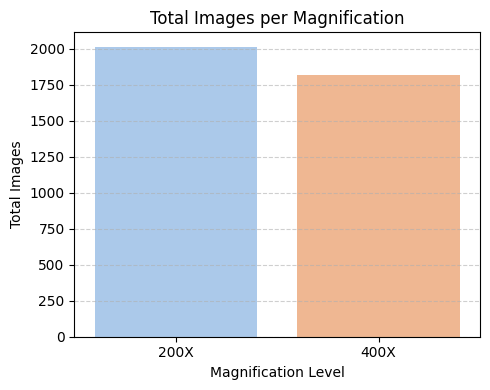

In [ ]:

# STEP — PLOT SIDE-BY-SIDE BARS FOR 200X & 400X

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data (reuse df from previous cell)
df_melted = df[['Benign', 'Malignant']].reset_index().melt(
    id_vars='index', var_name='Class', value_name='Count'
)
df_melted.rename(columns={'index': 'Magnification'}, inplace=True)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_melted,
    x='Magnification',
    y='Count',
    hue='Class',
    palette=['#66b3ff', '#ff6666'],
    dodge=True
)

plt.title("Benign vs Malignant Image Counts — 200X vs 400X", fontsize=13)
plt.xlabel("Magnification Level")
plt.ylabel("Number of Images")
plt.legend(title="Class")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Also show total comparison (optional)
plt.figure(figsize=(5,4))
sns.barplot(x=df.index, y=df['Total'], palette='pastel')
plt.title("Total Images per Magnification")
plt.xlabel("Magnification Level")
plt.ylabel("Total Images")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


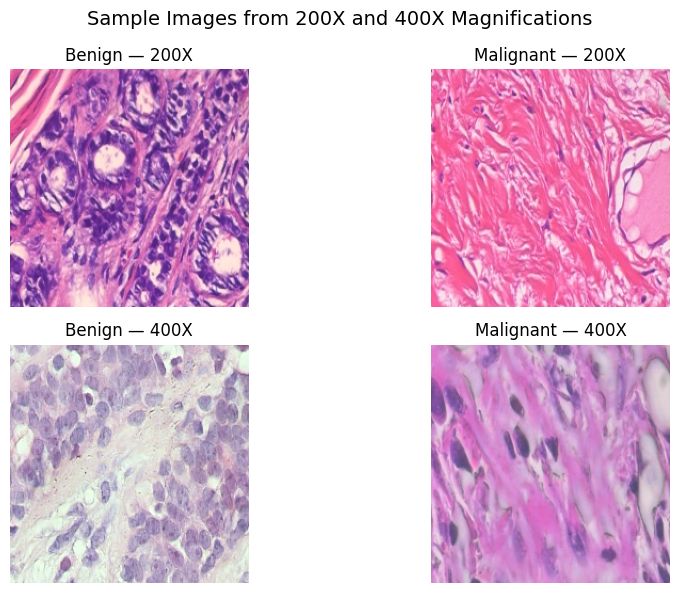

In [ ]:

#  DISPLAY SAMPLE IMAGES FROM 200X AND 400X DATASETS

import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define base paths for both magnifications
base_path = "/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria"
magnifications = ["200X", "400X"]

# Prepare list to store samples (label, magnification, path)
sample_paths = []

for mag in magnifications:
    mag_dir = os.path.join(base_path, mag)
    for label in ['benign', 'malignant']:
        for root, _, files in os.walk(mag_dir):
            if label in root.lower() and files:
                # randomly pick one image per class per magnification
                sample_paths.append((label, mag, os.path.join(root, random.choice(files))))
                break


# Plot samples

plt.figure(figsize=(10, 6))

for i, (label, mag, path) in enumerate(sample_paths):
    img = Image.open(path)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"{label.capitalize()} — {mag}")
    plt.axis('off')

plt.suptitle("Sample Images from 200X and 400X Magnifications", fontsize=14)
plt.tight_layout()
plt.show()


# **Model Training and Evaluation**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
# Set your dataset path exactly as shown in your folder
data_dir = "/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria/200X"
print(os.listdir(data_dir))  # should show ['benign', 'malignant']


['benign', 'malignant']


In [ ]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 1611 images belonging to 2 classes.
Found 402 images belonging to 2 classes.


In [ ]:
def build_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_model = build_model(vgg_base)

history_vgg = vgg_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 887ms/step - accuracy: 0.5872 - loss: 0.6780 - val_accuracy: 0.6915 - val_loss: 0.6312
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 566ms/step - accuracy: 0.6531 - loss: 0.6514 - val_accuracy: 0.6915 - val_loss: 0.6346
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 589ms/step - accuracy: 0.7049 - loss: 0.5994 - val_accuracy: 0.6915 - val_loss: 0.6373
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 571ms/step - accuracy: 0.7145 - loss: 0.5761 - val_accuracy: 0.6915 - val_loss: 0.6307
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 570ms/step - accuracy: 0.7180 - loss: 0.5722 - val_accuracy: 0.6866 - val_loss: 0.6431
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 583ms/step - accuracy: 0.6992 - loss: 0.5729 - val_accuracy: 0.6891 - val_loss: 0.6560
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 570ms/step - accuracy: 0.7095 - loss: 0.5781 - val_accuracy: 0.6915 - val_loss: 0.6572
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 590ms/step - accuracy: 0.7342 - loss: 0.5384 - val_accu

In [ ]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
resnet_model = build_model(resnet_base)

history_resnet = resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 53s 799ms/step - accuracy: 0.6338 - loss: 0.6702 - val_accuracy: 0.6915 - val_loss: 0.6188
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 639ms/step - accuracy: 0.6676 - loss: 0.6583 - val_accuracy: 0.6915 - val_loss: 0.6230
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 534ms/step - accuracy: 0.6930 - loss: 0.6322 - val_accuracy: 0.6915 - val_loss: 0.6122
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 535ms/step - accuracy: 0.6587 - loss: 0.6502 - val_accuracy: 0.6915 - val_loss: 0.6098
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 548ms/step - accuracy: 0.6877 - loss: 0.6279 - val_accuracy: 0.6915 - val_loss: 0.6097
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 544ms/step - accuracy: 0.6795 - loss: 0.6419 - val_accuracy: 0.6915 - val_loss: 0.6062
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 535ms/step - accuracy: 0.7066 - loss: 0.6069 - val_accuracy: 0.6915 - val_loss: 0.6083
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 525m

In [ ]:
eff_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
eff_model = build_model(eff_base)

history_eff = eff_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6852 - loss: 0.6400 - val_accuracy: 0.6915 - val_loss: 0.6199
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 504ms/step - accuracy: 0.6840 - loss: 0.6273 - val_accuracy: 0.6915 - val_loss: 0.6199
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 502ms/step - accuracy: 0.6921 - loss: 0.6222 - val_accuracy: 0.6915 - val_loss: 0.6179
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 502ms/step - accuracy: 0.6910 - loss: 0.6208 - val_accuracy: 0.6915 - val_loss: 0.6198
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 506ms/step - accuracy: 0.6966 - loss: 0.6175 - val_accuracy: 0.6915 - val_loss: 0.6183
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 505ms/step - accuracy: 0.7069 - loss: 0.6088 - val_accuracy: 0.6915 - val_loss: 0.6179
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 518ms/step - accuracy: 0.6865 - loss: 0.6274 - val_accuracy: 0.6915 - val_loss: 0.6183
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 538ms/s


Evaluating Model: VGG16
VGG16 - Validation Accuracy: 67.66%

Classification Report:
              precision    recall  f1-score   support

      benign       0.39      0.06      0.10       124
   malignant       0.70      0.96      0.81       278

    accuracy                           0.68       402
   macro avg       0.54      0.51      0.45       402
weighted avg       0.60      0.68      0.59       402

Precision: 0.6953
Recall:    0.9604
F1-Score:  0.8066


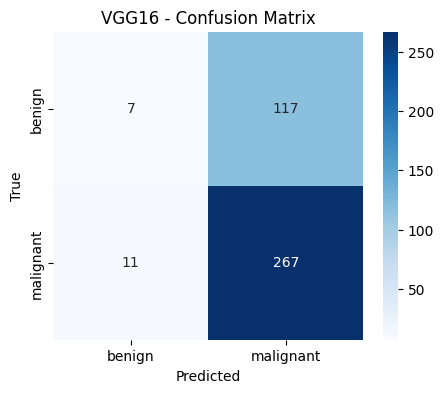


Evaluating Model: ResNet50
ResNet50 - Validation Accuracy: 69.15%

Classification Report:
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00       124
   malignant       0.69      1.00      0.82       278

    accuracy                           0.69       402
   macro avg       0.35      0.50      0.41       402
weighted avg       0.48      0.69      0.57       402

Precision: 0.6915
Recall:    1.0000
F1-Score:  0.8176


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


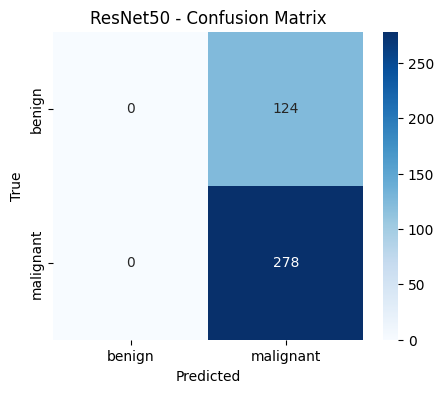


Evaluating Model: EfficientNetB0
EfficientNetB0 - Validation Accuracy: 69.15%

Classification Report:
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00       124
   malignant       0.69      1.00      0.82       278

    accuracy                           0.69       402
   macro avg       0.35      0.50      0.41       402
weighted avg       0.48      0.69      0.57       402

Precision: 0.6915
Recall:    1.0000
F1-Score:  0.8176


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


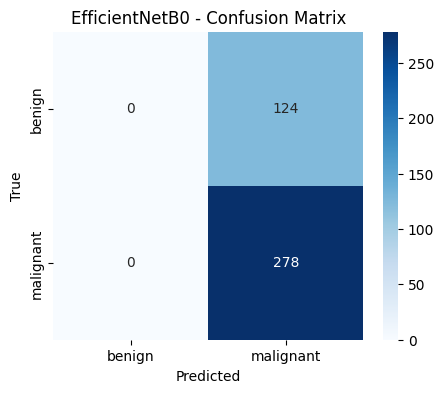


=== Overall Model Comparison ===


,Accuracy,Precision,Recall,F1-Score
VGG16,0.676617,0.695312,0.960432,0.806647
ResNet50,0.691542,0.691542,1.000000,0.817647
EfficientNetB0,0.691542,0.691542,1.000000,0.817647


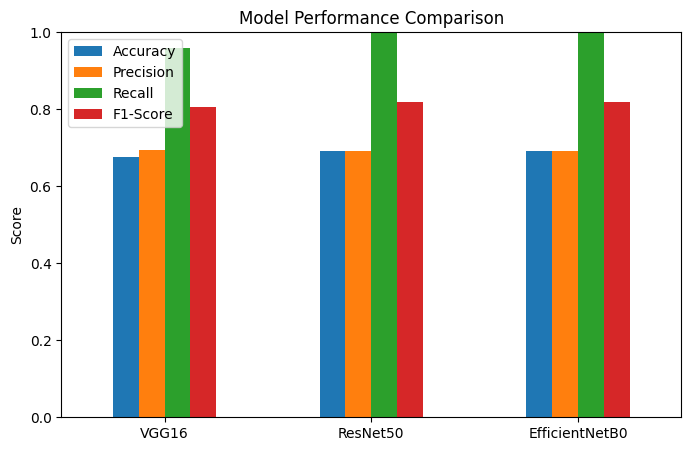

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, data, model_name):
    print(f"\n{'='*60}")
    print(f"Evaluating Model: {model_name}")
    print(f"{'='*60}")

    # Evaluate on validation data
    val_loss, val_acc = model.evaluate(data, verbose=0)
    print(f"{model_name} - Validation Accuracy: {val_acc*100:.2f}%")

    # Get predictions
    preds = model.predict(data, verbose=0)
    y_pred = np.round(preds).astype(int).flatten()
    y_true = data.classes

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(data.class_indices.keys())))

    # Calculate metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(data.class_indices.keys()),
                yticklabels=list(data.class_indices.keys()))
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return val_acc, precision, recall, f1


#  Evaluate all models
results = {}

models = {
    "VGG16": vgg_model,
    "ResNet50": resnet_model,
    "EfficientNetB0": eff_model
}

for name, model in models.items():
    acc, prec, rec, f1 = evaluate_model(model, val_data, name)
    results[name] = [acc, prec, rec, f1]

#  Compare All Model Results
import pandas as pd

results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-Score']).T
print("\n=== Overall Model Comparison ===")
display(results_df)

results_df.plot(kind='bar', figsize=(8,5), title="Model Performance Comparison", rot=0)
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()
